# Quantum Teleportation

This notebook demonstrates quantum teleportation. We first use Qiskit's built-in simulators to test our quantum circuit, and then try it out on a real quantum computer.

## Contents

1. Overview
2. The Quantum Teleportation Protocol       
3. Simulating the Teleportation Protocol   
    3.1 How will we Test this Result on a Real Quantum Computer?
    3.2 Using the Statevector Simulator     
    3.3 [Using the QASM Simulator
4. Teleportation on a Real Quantum Computer
    4.1 IBM hardware and Deferred Measurement
    4.2 Executing
4. References



## 1. Overview <a id='overview'></a>

Alice wants to send quantum information to Bob. Specifically, suppose she wants to send the qubit state
$\vert\psi\rangle = \alpha\vert0\rangle + \beta\vert1\rangle$. 
This entails passing on information about $\alpha$ and $\beta$ to Bob.

There exists a theorem in quantum mechanics which states that you cannot simply make an exact copy of an unknown quantum state. This is known as the no-cloning theorem. As a result of this we can see that Alice can't simply generate a copy of $\vert\psi\rangle$ and give the copy to Bob. We can only copy classical states (not superpositions).

However, by taking advantage of two classical bits and an entangled qubit pair, Alice can transfer her state $\vert\psi\rangle$ to Bob. We call this teleportation as at the end Bob will have $\vert\psi\rangle$ and Alice won't anymore.

## 2. The Quantum Teleportation Protocol
To transfer a quantum bit, Alice and Bob must use a third party (Eve) to send them an entangled qubit pair. Alice them performs some operations on her qubit, sends the results to Bob over a classical communication channel, and Bob then performs some operations on his end to receive Alice’s qubit.

We will describe the steps on a quantum circuit below. Here, no qubits are actually ‘sent’, you’ll just have to imagine that part!

First we set up our session:

In [24]:
# Do the necessary imports
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer, IBMQ
from qiskit.visualization import plot_histogram, plot_bloch_multivector

and create our quantum circuit:

In [25]:
qr = QuantumRegister(3)    # Protocol uses 3 qubits
crz = ClassicalRegister(1) # and 2 classical bits
crx = ClassicalRegister(1) # in 2 different registers
teleportation_circuit = QuantumCircuit(qr, crz, crx)

#### Step 1
A third party, Eve, creates an entangled pair of qubits and gives one to Bob and one to Alice.

The pair Eve creates is a special pair called a Bell pair. In quantum circuit language, the way to create a Bell pair between two qubits is to first transfer one of them to the X-basis ($|+\rangle$ and $|-\rangle$) using a Hadamard gate, and then to apply a CNOT gate onto the other qubit controlled by the one in the X-basis. 

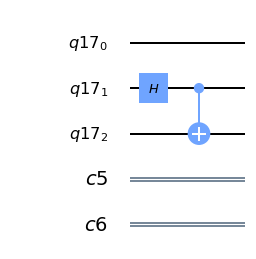

In [26]:
def create_bell_pair(qc, a, b):
    """Creates a bell pair in qc using qubits a & b"""
    qc.h(a) # Put qubit a into state |+>
    qc.cx(a,b) # CNOT with a as control and b as target

# In our case, Eve entangles qubits q1 and q2
# Let's apply this to our circuit:
create_bell_pair(teleportation_circuit, 1, 2)
# And view the circuit so far:
teleportation_circuit.draw()

Let's say Alice owns $q_1$ and Bob owns $q_2$ after they part ways.

#### Step 2 

Alice applies a CNOT gate to $q_1$, controlled by $\vert\psi\rangle$ (the qubit she is trying to send Bob). Then Alice applies a Hadamard gate to $|\psi\rangle$. In our quantum circuit, the qubit ($|\psi\rangle$) Alice is trying to send is $q_0$:

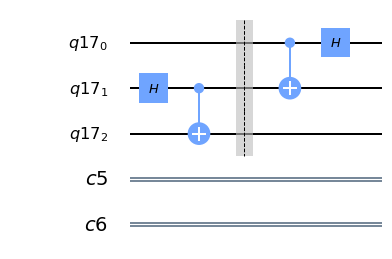

In [27]:
def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)
    
# Let's apply this to our circuit:
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)
teleportation_circuit.draw()

#### Step 3

Next, Alice applies a measurement to both qubits that she owns, $q_1$ and $\vert\psi\rangle$, and stores this result in two classical bits. She then sends these two bits to Bob.

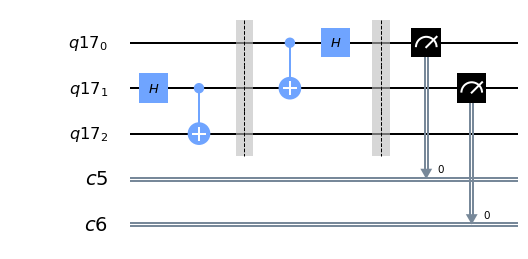

In [28]:
def measure_and_send(qc, a, b):
    """Measures qubits a & b and 'sends' the results to Bob"""
    qc.barrier()
    qc.measure(a,0)
    qc.measure(b,1)

measure_and_send(teleportation_circuit, 0 ,1)
teleportation_circuit.draw()

**Step 4**: Bob, who already has the qubit $q_2$, then applies the following gates depending on the state of the classical bits:

00 $\rightarrow$ Do nothing

01 $\rightarrow$ Apply $X$ gate

10 $\rightarrow$ Apply $Z$ gate

11 $\rightarrow$ Apply $ZX$ gate

(*Note that this transfer of information is purely classical*.)

In [29]:
# This function takes a QuantumCircuit (qc), integer (qubit)
# and ClassicalRegisters (crz & crx) to decide which gates to apply
def bob_gates(qc, qubit, crz, crx):
    # Here we use c_if to control our gates with a classical
    # bit instead of a qubit
    qc.z(qubit).c_if(crz, 1) # Apply gates if the registers 
    qc.x(qubit).c_if(crx, 1) # are in the state '1'

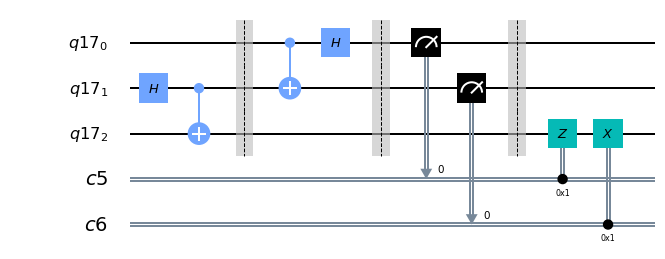

In [30]:
# Let's apply this to our circuit:
teleportation_circuit.barrier() # Use barrier to separate steps
bob_gates(teleportation_circuit, 2, crz, crx)
teleportation_circuit.draw()

And voila! At the end of this protocol, Alice's qubit has now teleported to Bob.

## 3. Simulating the Teleportation Protocol <a id='simulating'></a>

### 3.1 How Will We Test the Protocol on a Quantum Computer? <a id='testing'></a>

In this notebook, we will initialise Alice's qubit in a random state $\vert\psi\rangle$ (`psi`). This state will be created using an `Initialize` gate on $|q_0\rangle$. In this chapter we use the function `random_state` to choose `psi` for us, but feel free to set `psi` to any qubit state you want.


$$ |\psi\rangle =\begin{bmatrix}
-0.73996-0.61776j \\
-0.26406+0.03318j\end{bmatrix} $$

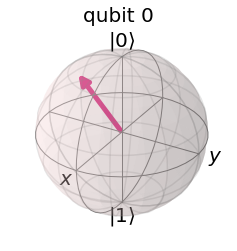

In [31]:
from qiskit_textbook.tools import random_state, vector2latex
# Create random 1-qubit state
psi = random_state(1)

# Display it nicely
vector2latex(psi, pretext="|\\psi\\rangle =")
# Show it on a Bloch sphere
plot_bloch_multivector(psi)

Let's create our initialisation gate to create $|\psi\rangle$ from the state $|0\rangle$:

In [32]:
from qiskit.extensions import Initialize
init_gate = Initialize(psi)

If the quantum teleportation circuit works, then at the end of the circuit the qubit $|q_2\rangle$ will be in this state. We will check this using the statevector simulator.

### 3.2 Using the Statevector Simulator <a id='simulating-sv'></a>

We can use the statevector simulator to verify our qubit has been teleported.

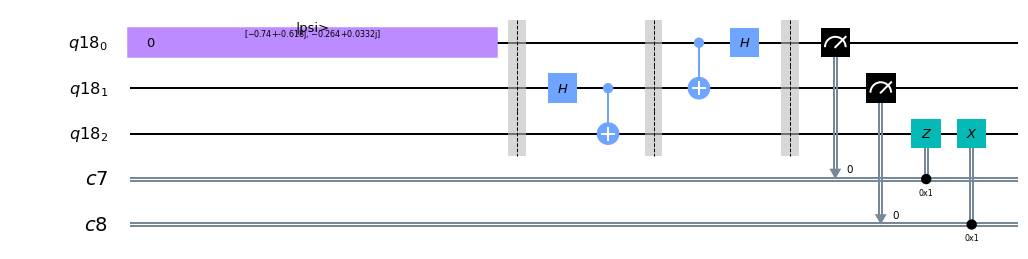

In [33]:
qr = QuantumRegister(3)   # Protocol uses 3 qubits
crz = ClassicalRegister(1) # and 2 classical registers
crx = ClassicalRegister(1)
qc = QuantumCircuit(qr, crz, crx)

# First, let's initialise Alice's q0
qc.append(init_gate, [0])
qc.barrier()

# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)

# Alice then sends her classical bits to Bob
measure_and_send(qc, 0, 1)

# Bob decodes qubits
bob_gates(qc, 2, crz, crx)

qc.draw()

At the time of writing, there is a rendering issue with the `Initialise` gate in the image above, but the circuit operates just fine. We can see below, using our statevector simulator, that the state of $|q_2\rangle$ is the same as the state $|\psi\rangle$ we created above, while the states of $|q_0\rangle$ and $|q_1\rangle$ have been collapsed to either $|0\rangle$ or $|1\rangle$. The state $|\psi\rangle$ has been teleported from qubit 0 to qubit 2.

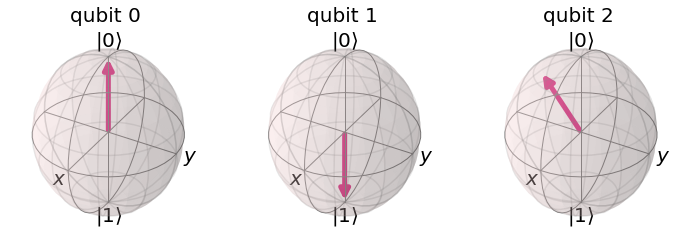

In [34]:
backend = BasicAer.get_backend('statevector_simulator')
out_vector = execute(qc, backend).result().get_statevector()
plot_bloch_multivector(out_vector)

You can run this cell a few times to make sure. You may notice that the qubits 0 & 1 change states, but qubit 2 is always in the state $|\psi\rangle$.

### 3.3 Using the QASM Simulator <a id='simulating-qs'></a>

Quantum teleportation is designed to send qubits between two parties. We do not have the hardware to demonstrate this, but we can demonstrate that the gates perform the correct transformations on a single quantum chip. Here we use the QASM simulator to simulate how we might test our protocol.

On a real quantum computer, we would not be able to sample the statevector, so if we wanted to check our teleportation circuit is working, we need to do things slightly differently. You will remember that we used `Initialize` to turn our $|0\rangle$ qubit into the state $|\psi\rangle$:

$$ |0\rangle \xrightarrow{\text{Initialise}} |\psi\rangle $$

Since all quantum gates are reversible, we can find the the inverse of Initialise using:

In [35]:
inverse_init_gate = init_gate.gates_to_uncompute()

This operation has the property:

$$ |\psi\rangle \xrightarrow{\text{Inverse Initialise}} |0\rangle $$

To prove the qubit $|q_0\rangle$ has been teleported to $|q_2\rangle$, if we do this inverse initialisation on $|q_2\rangle$, we expect to measure $|0\rangle$ with certainty. We do this in the circuit below:

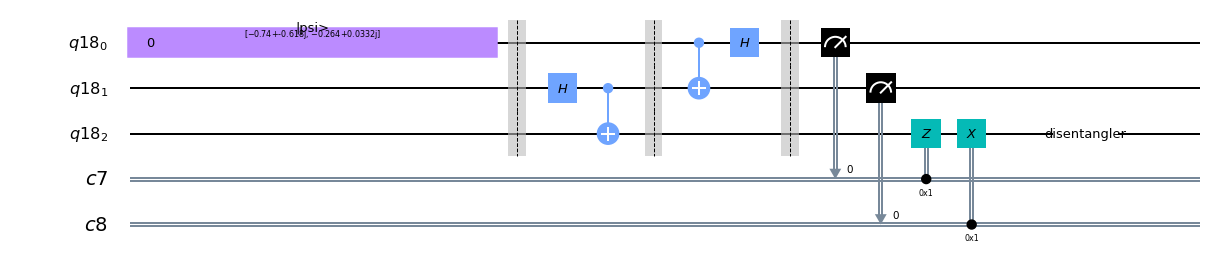

In [36]:
qc.append(inverse_init_gate, [2])
qc.draw()

Again, there is a rendering issue with the `inverse_init_gate` (called 'disentangler' on the circuit diagram), but we can clearly see the gate appearing in the image. Finally, we measure to the third classical bit to see our output:

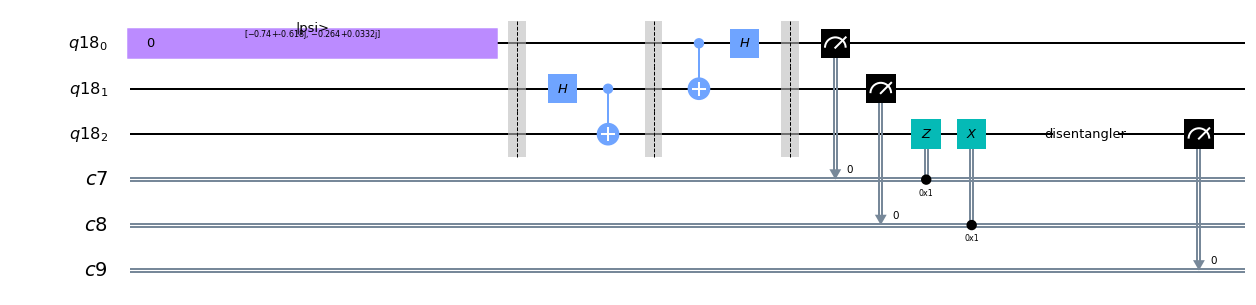

In [37]:
# Need to add a new ClassicalRegister
# to see the result
cr_result = ClassicalRegister(1)
qc.add_register(cr_result)
qc.measure(2,2)
qc.draw()

and we run our experiment:

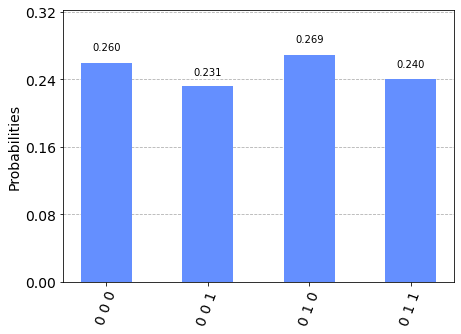

In [38]:
backend = BasicAer.get_backend('qasm_simulator')
counts = execute(qc, backend, shots=1024).result().get_counts()
plot_histogram(counts)

We can see we have a 100% chance of measuring $q_2$ (the leftmost bit in the string) in the state $|0\rangle$. This is the expected result, and indicates the teleportation protocol has worked properly.

## 4. Teleportation on a Real Quantum Computer <a id='real_qc'></a>

### 4.1 IBM hardware and Deferred Measurement <a id='deferred-measurement'></a>

The IBM quantum computers currently do not support instructions after measurements, meaning we cannot run the quantum teleportation in its current form on real hardware. Fortunately, this does not limit our ability to perform any computations due to the _deferred measurement principle_ [1]. The principle states that any measurement can be postponed until the end of the circuit, i.e. we can move all the measurements to the end, and we should see the same results.

Any benefits of measuring early are hardware related: If we can measure early, we may be able to reuse qubits, or reduce the amount of time our qubits are in their fragile superposition. In this example, the early measurement in quantum teleportation would have allowed us to transmit a qubit state without a direct quantum communication channel.

While moving the gates allows us to demonstrate the "teleportation" circuit on real hardware, it should be noted that the benefit of the teleportation process (transferring quantum states via classical channels) is lost.

Let us re-write the `bob_gates` function:

In [39]:
def bob_gates(qc, a, b, c):
    qc.cz(a, c)
    qc.cx(b, c)

And create our new circuit:

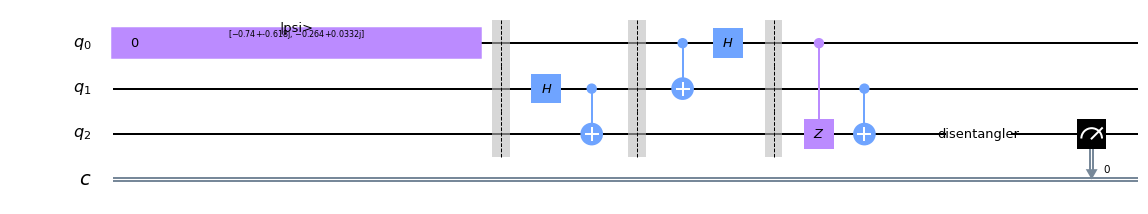

In [40]:
qc = QuantumCircuit(3,1)

# First, let's initialise Alice's q0
qc.append(init_gate, [0])
qc.barrier()

# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)
qc.barrier()
# Alice sends classical bits to Bob
bob_gates(qc, 0, 1, 2)

# We undo the initialisation process
qc.append(inverse_init_gate, [2])

# See the results, we only care about the state of qubit 2
qc.measure(2,0)

# View the results:
qc.draw()

### 4.2 Executing <a id='executing'></a> 

In [41]:
# First, see what devices we are allowed to use by loading our saved accounts
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()

Credentials are already in use. The existing account in the session will be replaced.


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [42]:
# get the least-busy backend at IBM and run the quantum circuit there
from qiskit.providers.ibmq import least_busy
backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and
                                   not b.configuration().simulator and b.status().operational==True))
job_exp = execute(qc, backend=backend, shots=8192)

{'1': 2815, '0': 5377}


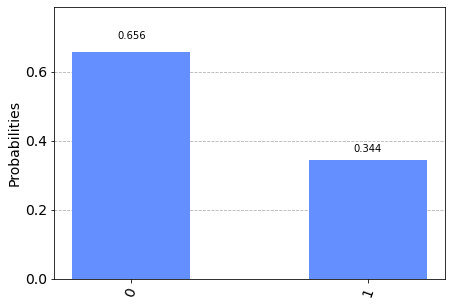

In [43]:
# Get the results and display them
exp_result = job_exp.result()
exp_measurement_result = exp_result.get_counts(qc)
print(exp_measurement_result)
plot_histogram(exp_measurement_result)

As we see here, there are a few results in which we measured $|1\rangle$. These arise due to errors in the gates and the qubits. In contrast, our simulator in the earlier part of the notebook had zero errors in its gates, and allowed error-free teleportation.

In [44]:
error_rate_percent = sum([exp_measurement_result[result] for result in exp_measurement_result.keys() if result[0]=='1']) \
                    * 100./ sum(list(exp_measurement_result.values()))
print("The experimental error rate : ", error_rate_percent, "%")

The experimental error rate :  34.36279296875 %


## 5. References <a id='references'></a>
[1] M. Nielsen and I. Chuang, Quantum Computation and Quantum Information, Cambridge Series on Information and the Natural Sciences (Cambridge University Press, Cambridge, 2000).

In [45]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.12.0',
 'qiskit-aer': '0.4.1',
 'qiskit-ignis': '0.2.0',
 'qiskit-ibmq-provider': '0.5.0',
 'qiskit-aqua': '0.6.5',
 'qiskit': '0.16.2'}